# LSH

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.mllib.random import RandomRDDs
from pyspark.ml.feature import *
# Create SparkSession
spark = SparkSession.builder.appName("asheesh").getOrCreate()

22/04/05 09:12:52 WARN Utils: Your hostname, a-Lenovo-Legion-Y530-15ICH resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface wlp7s0)
22/04/05 09:12:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/05 09:12:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/05 09:12:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/05 09:12:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/05 09:12:53 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/04/05 09:12:53 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
def generate_random_uniform_df(nrows=10, ncols=10,numPartitions=10):
    return RandomRDDs.uniformVectorRDD(spark.sparkContext, nrows,ncols,numPartitions).map(lambda a : a.tolist()).toDF()

df=generate_random_uniform_df(nrows=1000,ncols=10,numPartitions=100)

In [3]:
vectorAssembler = VectorAssembler(inputCols=df.columns, outputCol="rawFeatures")
df=vectorAssembler.transform(df)

In [4]:

df=df.withColumn("id", F.udf(lambda z: int(z*10000),IntegerType())(df._1))


In [5]:
df.groupBy("id").count().orderBy("count",ASEC=False).show()

[Stage 1:=======================================================>(99 + 1) / 100]

+----+-----+
|  id|count|
+----+-----+
|8105|    1|
|5030|    1|
|2622|    1|
|5433|    1|
|2833|    1|
|2096|    1|
|3425|    1|
|8665|    1|
|5100|    1|
|2572|    1|
|  31|    1|
|8257|    1|
|1903|    1|
|9162|    1|
|5071|    1|
|8409|    1|
|9564|    1|
|6773|    1|
|1721|    1|
|6623|    1|
+----+-----+
only showing top 20 rows



In [6]:
dfA,dfB = df.randomSplit([0.7, 0.3])
print(dfA.count(),"  ",dfB.count())

[Stage 5:=============================================>         (83 + 12) / 100]

703    297


# LSH Algorithm

In [8]:
brp = BucketedRandomProjectionLSH(inputCol="rawFeatures", outputCol="hashes", bucketLength=10.0,
                                  numHashTables=20)
model = brp.fit(dfA)


Compute the locality sensitive hashes for the input rows, then perform approximate similarity join.
We could avoid computing hashes by passing in the already-transformed dataset, e.g. `model.approxSimilarityJoin(transformedA, transformedB, 1.5)

In [9]:
from pyspark.sql.functions import col
print("Approximately joining dfA and dfB on Euclidean distance smaller than 1.5:")
lsh_df=model.approxSimilarityJoin(dfA, dfB, 1.5, distCol="EuclideanDistance")
# lsh_df.show()
lsh_df.select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("EuclideanDistance")).show()

Approximately joining dfA and dfB on Euclidean distance smaller than 1.5:


22/04/05 09:13:34 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
22/04/05 09:13:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/05 09:13:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
[Stage 10:=====================================================>(198 + 2) / 200]

+----+----+------------------+
| idA| idB| EuclideanDistance|
+----+----+------------------+
|  20|3230| 1.231125742654328|
|5376|5915|1.3810017352027988|
|9790|1348|1.4874629848527583|
|9936|3034|1.2469985021245635|
|   2|1480|0.9012163558785872|
|   2| 572|1.1656274561665683|
|1590|8456|1.4378399705109939|
|1590|5815|1.3189332668082971|
|1590|6095|0.9902050814768991|
|1590|1520| 1.395929073804033|
|4401|5458|1.0211808659311876|
|4401|7050|   1.3808934209529|
|4401| 171| 1.351154051263136|
|7577|9322|1.0002963145082087|
|7577|8165| 1.205966741548178|
|7577|6412|1.3448780830470402|
|7965|8493|0.8168498875230408|
|9495|5678|0.9919285125735244|
|1755|1943|1.1609351593800161|
|1755|6184|  0.90314559504887|
+----+----+------------------+
only showing top 20 rows



In [11]:
print("Approximately searching dfA for 2 nearest neighbors of the key:")
# model.approxNearestNeighbors(dfA, dfB, 2).show()

Approximately searching dfA for 2 nearest neighbors of the key:


# Cosine Similarity

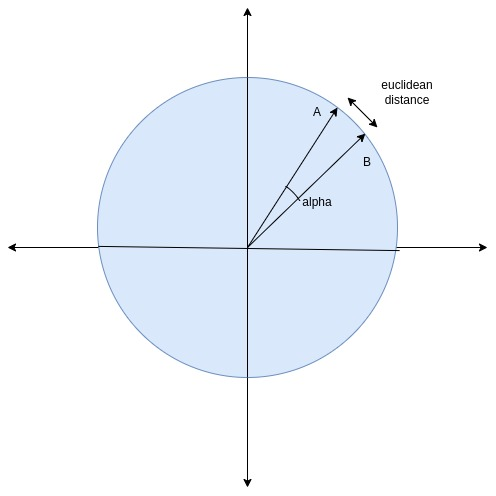

Similar vecotors:  Cos(0) = 1  ->  euclidean distance ~= 0

In [12]:
# https://app.diagrams.net/#G1xeVNL85KDCzasR7CkX4XEYFUIRBrdOuy
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
normalizer = Normalizer(inputCol="rawFeatures", outputCol="normFeatures", p=2.0)


In [13]:
l1_dfA = normalizer.transform(dfA)
l2_dfB= normalizer.transform(dfB)

In [14]:
lsh_df=model.approxSimilarityJoin(l1_dfA, l2_dfB, 0.5, distCol="EuclideanDistance")
# lsh_df.show()
lsh_df.select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("EuclideanDistance")).show()

[Stage 14:================================================>    (182 + 12) / 200]

+----+----+-------------------+
| idA| idB|  EuclideanDistance|
+----+----+-------------------+
|8108|8919| 0.4962024245821232|
|7030|3921| 0.4795859043310134|
|1395|4480| 0.4153188841834258|
|2013|1754|0.47113339003381394|
|1087|3921| 0.3950212362218264|
|9014|8919|0.40060290164912665|
|5857|3606|0.36362503626355835|
|4863|7204|0.49794676203444943|
| 656|1724| 0.4394315006989673|
|7945|9463|  0.443790116863545|
| 253|1641| 0.4713051797953725|
|3387|2802|0.45667650839081636|
|6276|7982| 0.4854498691567015|
| 889|3375| 0.4929480618107307|
|5153|6876| 0.4913911284738265|
|3067|1067| 0.4653196439217367|
|3067|5218|0.49178854005442024|
| 784| 640| 0.4207219832239372|
|7130|9046| 0.4823521054415736|
|5530|5275|0.45116182412629685|
+----+----+-------------------+
only showing top 20 rows

